# Hands-On Workshop: Hybrid Retrieval Process with LLM-Generated SPARQL Queries

Welcome to the hands-on workshop for the Hybrid Retrieval Process! This notebook demonstrates how to use vector search and SPARQL queries to retrieve and analyze supplier information from both unstructured and structured data. The SPARQL queries will be dynamically generated using a Language Model (LLM).

<!-- 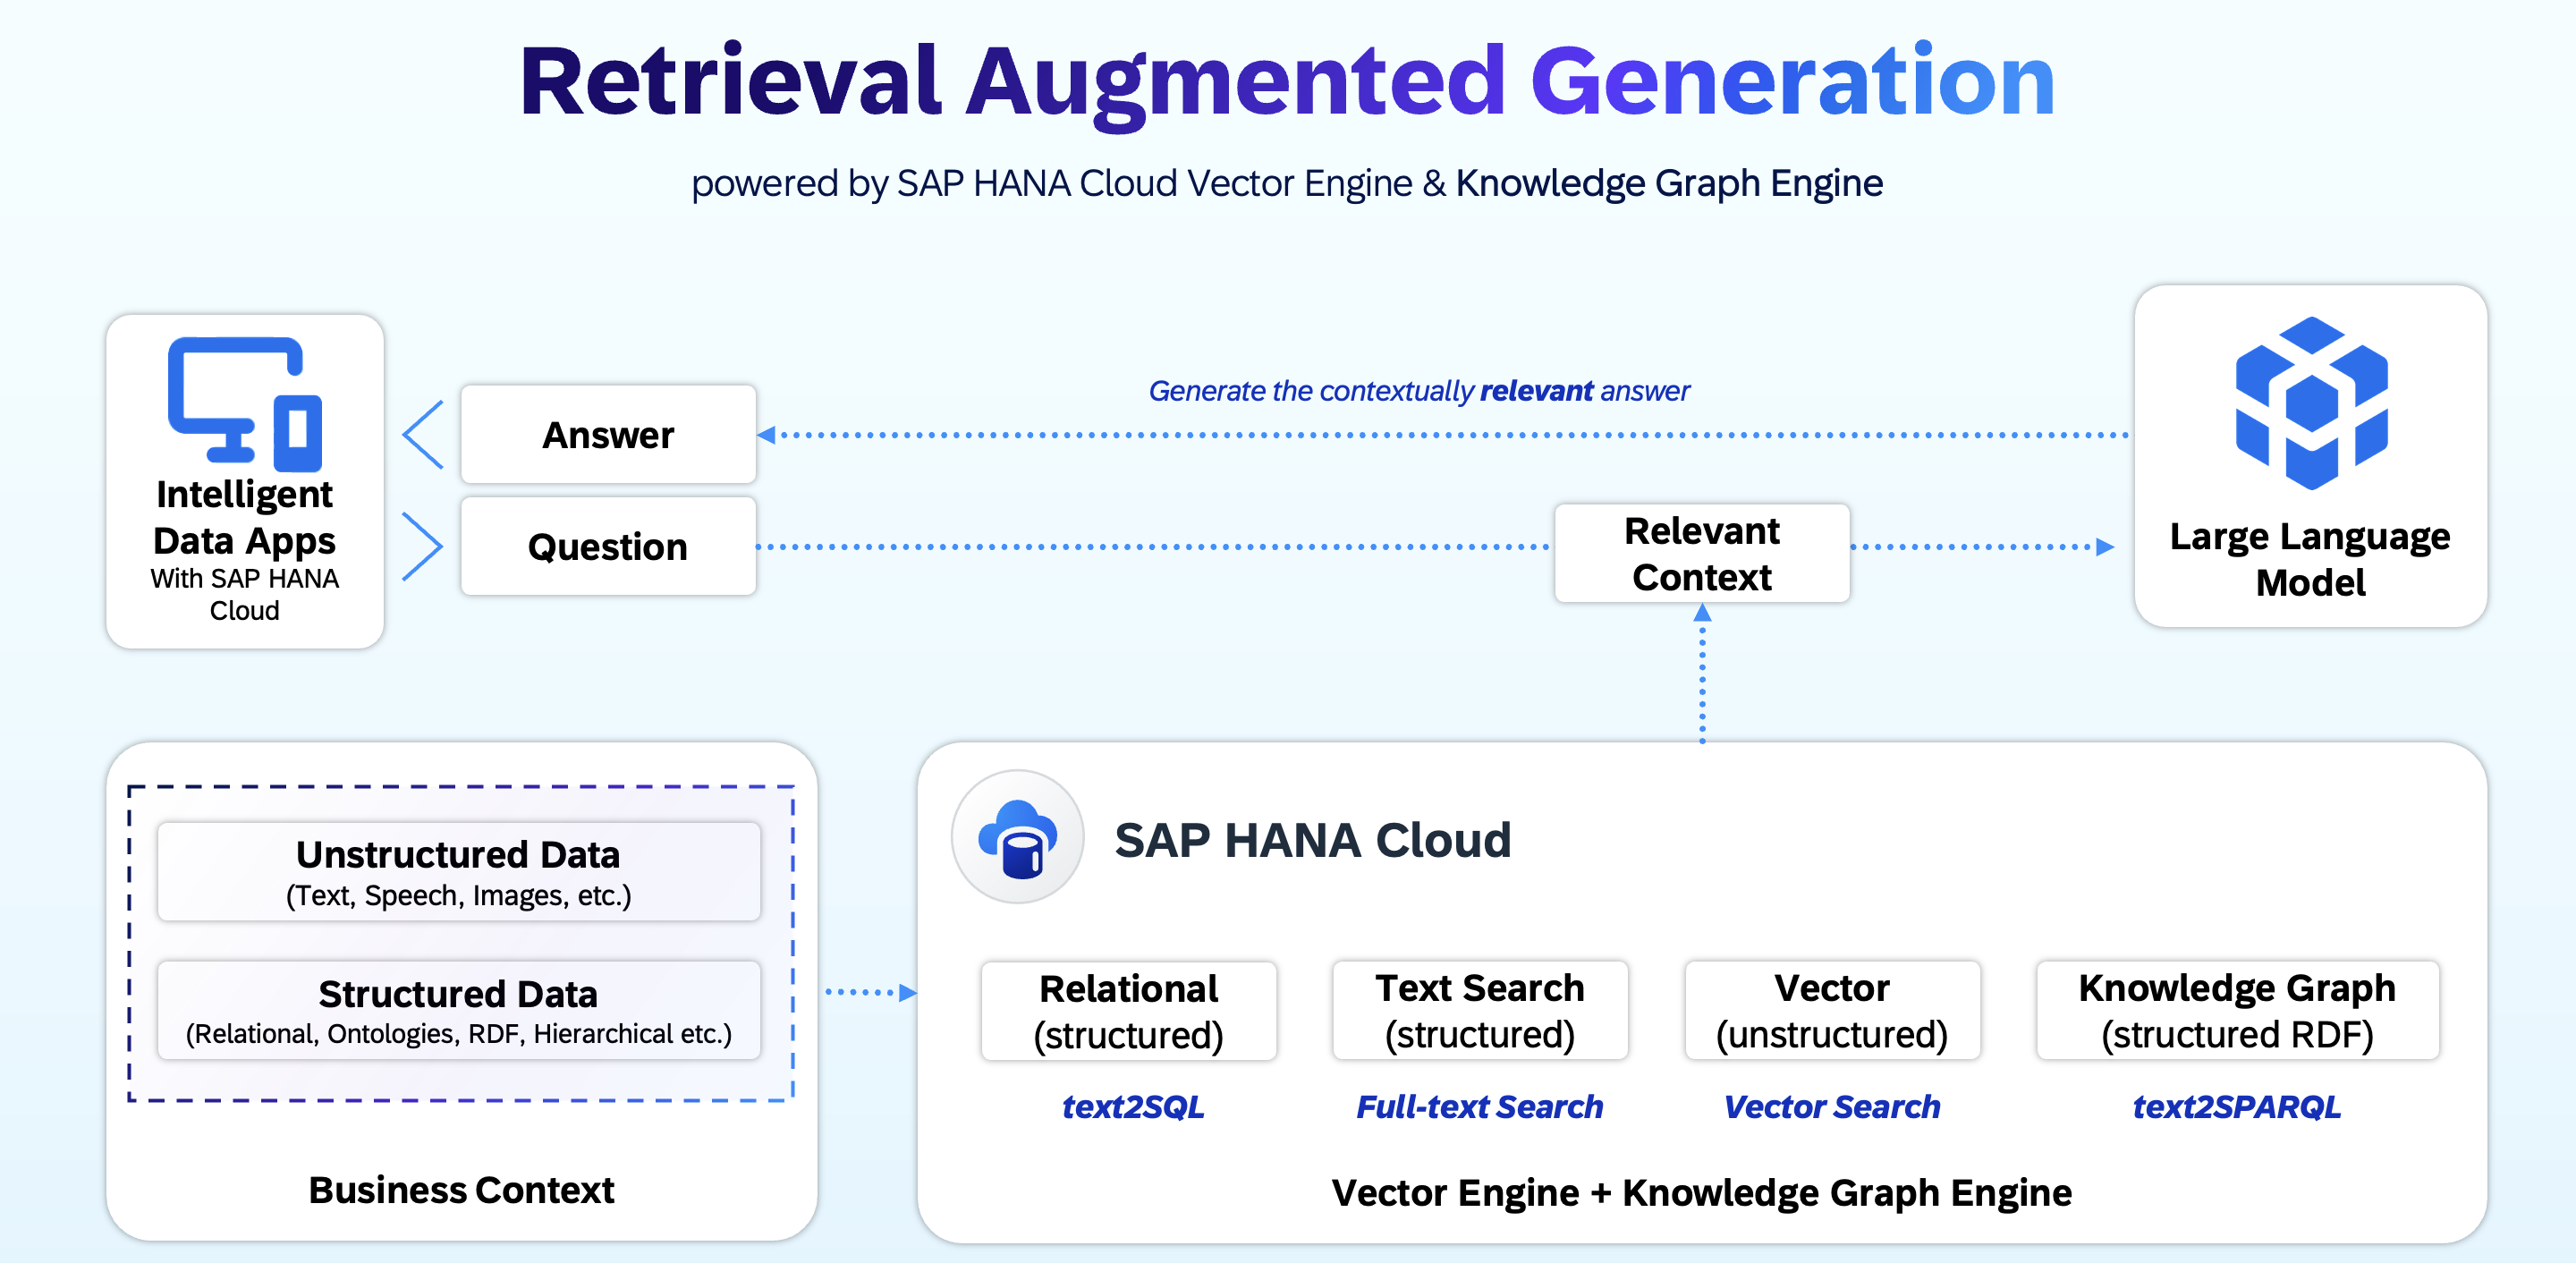 -->
<img src="img/01.png" alt="01.png" style="width: 70%;">

## Objectives
By the end of this workshop, you will:
- Understand how to initialize and use the hybrid retrieval process.
- Learn how to generate SPARQL queries dynamically using LLMs.
- Combine results from vector search and SPARQL to generate meaningful answers.

## Prerequisites
Before running this notebook, ensure the following:
- Python 3.11 or higher is installed.
- All dependencies listed in `requirements.txt` are installed.
- The configuration files (`env_cloud.json` and `env_config.json`) are properly set up in the `config/` directory.
- The SAP HANA database is accessible and contains the required data.

## Setup and configuration

#### Install Python packages

Run the following package installations. **pip** is the package installer for Python. You can use pip to install packages from the Python Package Index and other indexes.

In [ ]:
%pip install generative-ai-hub-sdk[all] --break-system-packages
%pip install hdbcli --break-system-packages
%pip install langchain-hana --break-system-packages

# kernel restart required!!!

#### Restart Python kernel

The Python kernel needs to be restarted before continuing. 

> 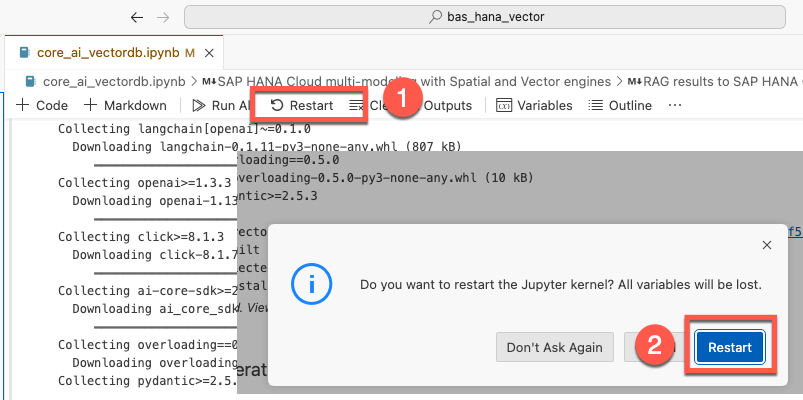

#### Configure SAP Generative AI Hub credentials

Execute the configuration module below to enable access to SAP Generative AI foundation models. This configuration is automatically done by running configuration module in the code block.

You could also set up the same by running a terminal command: **aicore configure**



> Please ensure that the Python kernel was restarted!


In [ ]:
# Generative AI Config
import os
import json

# Use the current working directory for Jupyter Notebook
base_path = os.getcwd()
config_path = os.path.join(base_path, 'config', 'env_config.json')

# Load the configuration file
with open(config_path) as f:
    aicore_config = json.load(f)

print("Configuration loaded successfully!" + str(aicore_config))

### Initialize AI Core Client, Proxy Client, and Language Model

In this step, we are setting up the AI Core client, initializing the GenAIHub proxy client, and configuring the embedding model and language model (LLM). These components are essential for interacting with SAP's Generative AI Hub and performing tasks such as generating embeddings and executing language model operations.

- **AICoreV2Client**: Connects to SAP AI Core using the provided configuration details (base URL, authentication URL, client ID, client secret, and resource group).
- **GenAIHubProxyClient**: Acts as a proxy client to interact with the Generative AI Hub via the AI Core client.
- **OpenAIEmbeddings**: Initializes the embedding model (`text-embedding-ada-002`) for generating vector embeddings.
- **ChatOpenAI**: Configures the language model (`gpt-4o`) for generating responses or performing tasks like SPARQL query generation.

In [ ]:
# Set llm
from ai_core_sdk.ai_core_v2_client import AICoreV2Client
from gen_ai_hub.proxy.gen_ai_hub_proxy import GenAIHubProxyClient
from gen_ai_hub.proxy.langchain.openai import OpenAIEmbeddings, ChatOpenAI

# Set up the AICoreV2Client
ai_core_client = AICoreV2Client(base_url=aicore_config['AICORE_BASE_URL'],
                            auth_url=aicore_config['AICORE_AUTH_URL'],
                            client_id=aicore_config['AICORE_CLIENT_ID'],
                            client_secret=aicore_config['AICORE_CLIENT_SECRET'],
                            resource_group=aicore_config['AICORE_RESOURCE_GROUP'])
# Initialize GenAIHub proxy client
proxy_client = GenAIHubProxyClient(ai_core_client=ai_core_client)

# Initialize embedding model and LLM
embedding_model = OpenAIEmbeddings(proxy_model_name='text-embedding-ada-002', proxy_client=proxy_client)
llm = ChatOpenAI(proxy_model_name='gpt-4o', proxy_client=proxy_client)

#### Connect to the HANA vector storage instance

The provided Python script imports database connection modules and initiates a connection to a SAP HANA Cloud instance using the `dbapi` module. The user is prompted to enter their username and password, which are then used to establish a secure connection to the SAP HANA Cloud database. 

In [ ]:
# HANA Cloud Config
from hdbcli import dbapi

# Use the current working directory for Jupyter Notebook
base_path = os.getcwd()
config_path = os.path.join(base_path, 'config', 'env_cloud.json')

# Load the configuration file
with open(config_path) as f:
    hana_env_c = json.load(f)

print("HANA Cloud configuration loaded successfully!" + str(hana_env_c))

# Establish a connection to the HANA Cloud database
connection = dbapi.connect( 
    address=hana_env_c['url'],
    port=hana_env_c['port'], 
    user=hana_env_c['user'], 
    password=hana_env_c['pwd']   
)

print("HANA Cloud connection established successfully!")

## Step 1: Extract Details From PDF & Generate Embeddings

In this step we will:
- Extract details from a PDF file 
- Generate vector embeddings by using a pre-trained embedding model.
- Insert the embeddings into the SAP HANA database for use in vector search.

### Extract Text Chunks from PDF

This step involves extracting text chunks from a PDF file using LangChain. The process includes:
- Loading the PDF file using `PyMuPDFLoader`.
- Splitting the text into smaller chunks using `CharacterTextSplitter` while preserving metadata such as page numbers.
- Returning the extracted chunks for further processing.

The extracted chunks will later be used to generate vector embeddings and insert them into the SAP HANA database.

In [ ]:
from langchain_community.document_loaders import PyMuPDFLoader
from langchain.text_splitter import CharacterTextSplitter

def extract_chunks_from_pdf_with_langchain(file_path: str, chunk_size: int = 500, chunk_overlap: int = 50):
    """
    Extracts text chunks from a PDF file using LangChain, preserving metadata like page number.
    
    Args:
        file_path (str): Path to the PDF file.
        chunk_size (int): Maximum size of each text chunk.
        chunk_overlap (int): Overlap size between chunks.
        
    Returns:
        List[Document]: List of LangChain Document objects with text and metadata.
    """
    # Step 1: Load the PDF using PyMuPDFLoader
    loader = PyMuPDFLoader(file_path)
    pages = loader.load()  # List of Documents, each corresponding to a page

    # Step 2: Initialize a text splitter
    text_splitter = CharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap)

    # Step 3: Split the documents into smaller chunks while preserving metadata
    chunks = text_splitter.split_documents(pages)

    return chunks

chunks = extract_chunks_from_pdf_with_langchain("sources/Supplier_Performance_Report_Detailed.pdf")
for chunk in chunks:
    print(chunk.metadata)
    print(chunk.page_content)



### Populate the table with data and creates a REAL_VECTOR column to store embeddings

Create a LangChain VectorStore interface for the HANA database and specify the table (collection) to use for accessing the vector embeddings. Embeddings are vector representations of text data that incorporate the semantic meaning of the text.

The `langchain_hana` library, specifically the `HanaDB` class, from the LangChain community, enables interaction with SAP HANA Cloud's vector storage capabilities. It provides tools to manage and query vector embeddings stored in SAP HANA Cloud, making it easier to implement workflows like Retrieval Augmented Generation (RAG) using SAP HANA's advanced database features.

In [ ]:
# Open dbapi connection
cursor = connection.cursor()

from langchain_hana import HanaDB
#Create a LangChain VectorStore interface for the HANA database and specify the table (collection) to use for accessing the vector embeddings

db = HanaDB(
    connection=connection,
    embedding=embedding_model,
    table_name="SUPPLIERS_EMBED_ADA_"+ hana_env_c['user'],
    content_column="CONTENT",
    metadata_column="METADATA",
    vector_column="VECTOR"
)

In [ ]:
# Delete already existing documents from the table
db.delete(filter={})

# add the loaded document chunks
db.add_documents(chunks)

### Verify product embeddings in SAP HANA Cloud

In [ ]:
# Query the table to verify embeddings
cursor = connection.cursor()
sql = f'SELECT CONTENT, TO_NVARCHAR(VECTOR) FROM "{db.table_name}"'

cursor.execute(sql)
vectors = cursor.fetchall()

for vector in vectors:
    print(vector)

## Step 2: Generate Knowledge Graph (KG)

Now we will build the Knowledge Graph by transforming our structured data into RDF triples and inserting the triples into the SAP HANA database.

### Load supplier and country data from CSV files.

In [ ]:
import pandas as pd
import math

# Load data
suppliers = pd.read_csv("sources/suppliers.csv", sep=";")
country_status = pd.read_csv("sources/country_status.csv", sep=";")
country_risk_map = dict(zip(country_status["COUNTRY"], country_status["RISK"]))

### Clean and transform the data into RDF triples.

**SPARQL DELETE Query**: The DELETE WHERE query removes all triples in the `<rag_suppliers>` graph before inserting new data.

In [ ]:
# Start building SPARQL DELETE and INSERT
sparql_delete = "PREFIX rag: <http://sap.com/rag/>\n\n"
sparql_delete += "DELETE WHERE {\n"
sparql_delete += "  GRAPH <rag_suppliers> {\n"
sparql_delete += "    ?s ?p ?o .\n"
sparql_delete += "  }\n}\n"

# Execute DELETE query
cursor.callproc('SPARQL_EXECUTE', (sparql_delete, '', '', None))
print(f"Previous data cleared ✅")

### Build the Knowledge Graph

In this step we are processing supplier data in batches and inserting it into a knowledge graph using **SPARQL** queries.

In [ ]:
# Batch parameters
batch_size = 50
total_suppliers = len(suppliers)
num_batches = math.ceil(total_suppliers / batch_size)

import re

# Function to clean and format URIs
# This function will remove spaces, special characters, and make the string URI-friendly
# It will also ensure that the string is lowercase and does not start with a number
def clean_uri(text):
    # text = text.lower()  # make lowercase
    text = text.strip()  # remove spaces at beginning/end
    text = text.replace(" ", "_")  # replace spaces with underscore
    text = re.sub(r'[^A-Za-z0-9_]', '', text)  # remove everything except a-z, 0-9, _
    return text

# Loop through the suppliers DataFrame in batches and build the SPARQL INSERT query for each batch
for batch_idx in range(num_batches):
    start_idx = batch_idx * batch_size
    end_idx = min(start_idx + batch_size, total_suppliers)
    batch = suppliers.iloc[start_idx:end_idx]
    
    # Start building batch SPARQL
    sparql_insert = "PREFIX rag: <http://sap.com/rag/>\n\n"
    sparql_insert += "INSERT DATA {\n"
    sparql_insert += "  GRAPH <rag_suppliers> {\n"
    
    for idx, row in batch.iterrows():
        supplier_name = clean_uri(row["SUPPLIER_NAME"])
        supplier_id = row["SUPPLIER_ID"]
        country = clean_uri(row["SUPPLIER_COUNTRY"])
        supplier_type = row["SUPPLIER_TYPE"]
        address = row["SUPPLIER_ADDRESS"]
        city = row["SUPPLIER_CITY"]
        email = row["SUPPLIER_EMAIL"]
        phone = row["SUPPLIER_PHONE"]
        website = row["SUPPLIER_WEBSITE"]

        sparql_insert += f"    rag:{supplier_name} rag:locatedIn rag:{country} .\n"
        sparql_insert += f"    rag:{supplier_name} rag:hasSupplierType \"{supplier_type}\" .\n"
        sparql_insert += f"    rag:{supplier_name} rag:hasSupplierId \"{supplier_id}\" .\n"
        sparql_insert += f'    rag:{supplier_name} rag:hasAddress "{address}" .\n'
        sparql_insert += f'    rag:{supplier_name} rag:locatedInCity "{city}" .\n'
        sparql_insert += f'    rag:{supplier_name} rag:hasEmail "{email}" .\n'
        sparql_insert += f'    rag:{supplier_name} rag:hasPhone "{phone}" .\n'
        sparql_insert += f'    rag:{supplier_name} rag:hasWebsite "{website}" .\n'
        
        if row["SUPPLIER_COUNTRY"] in country_risk_map:
            risk = country_risk_map[row["SUPPLIER_COUNTRY"]]
            sparql_insert += f"    rag:{country} rag:hasGeopoliticalRisk \"{risk}\" .\n"

    
    # Close SPARQL
    sparql_insert += "  }\n}"
    
    # Execute batch
    cursor.callproc('SPARQL_EXECUTE', (sparql_insert, '', '', None))
    print(f"Batch {batch_idx+1}/{num_batches} uploaded successfully ✅")

# Close connection
print("All batches uploaded! 🚀")

### Validate the Knowledge Graph (KG)

This code defines a SPARQL query to validate the knowledge graph by retrieving supplier information, including supplier type, country, and geopolitical risk, from the `<rag_suppliers>` graph. It executes the query using the `SPARQL_EXECUTE` stored procedure and prints the results along with response metadata. If the execution fails, an exception is raised.

In [ ]:
# Define a SPARQL query to validate the KG
validation_query = """
PREFIX rag: <http://sap.com/rag/>

SELECT ?supplier ?supplierType ?country ?risk
FROM <rag_suppliers>
WHERE {
    ?supplier rag:locatedIn ?country .
    ?supplier rag:hasSupplierType ?supplierType .
    ?country rag:hasGeopoliticalRisk ?risk .
}
LIMIT 10
"""

# Execute the SPARQL query
try:
    cursor = connection.cursor()
    resp = cursor.callproc('SPARQL_EXECUTE', (
        validation_query,
        'Accept: application/sparql-results+csv',
        '?',
        None
    ))
    metadata = resp[3]
    results = resp[2]
    
    # Print results
    print("Validation Query Results:")
    print(results)
    print("Response Metadata:", metadata)
except Exception as e:
    raise RuntimeError(f"SPARQL_EXECUTE failed: {e}")

## Step 3: Implement Hybrid Retrieval with HVE and KGE

Now that our **unstructured documents** have been uploaded into the **SAP HANA Cloud Vector Engine (HVE)** and the **Knowledge Graph** has been created for our **structured data**, we are ready to implement a **Hybrid Retrieval-Augmented Generation (RAG)** approach.

This approach combines the capabilities of:

- **SAP HANA Cloud Vector Engine (HVE)** → Retrieves relevant information from unstructured documents.
- **SAP HANA Cloud Knowledge Graph Engine (KGE)** → Retrieves structured facts and relationships using SPARQL queries.

Together, these engines enable context retrieval from both structured and unstructured sources, allowing for more accurate and comprehensive responses.


### Define the user question

In [ ]:
question = "I want to see all suppliers that are facing financial instability and are connected to regions with high geopolitical risks. Specify what issues are observed."

### Retrieve Vector context for the question from unstructured documents

In [ ]:
# Retrieve vector context
def retrieve_vector_context(question, top_k=25):
    retriever = db.as_retriever(search_kwargs={'k': top_k})
    return retriever.invoke(question)

vector_context = retrieve_vector_context(question)
print("Vector Context Retrieved:")
print(vector_context)

### Generate SPARQL Query with LLM
We will now generate a SPARQL query dynamically using the LLM based on the RDF context and the user question.

In [ ]:
# Define the context about your RDF schema
rdf_context = """
    Your RDF graph uses the following structure:

    Namespaces:
    - rag: <http://sap.com/rag/>

    Supplier entities (identified by SUPPLIER_NAME) have the following properties:
    - rag:locatedIn → the supplier's country (IRI reference).
    - rag:hasSupplierType → type of supplier (Literal: "Manufacturer" or "Reseller").
    - rag:hasSupplierId → supplier ID (Literal string).
    - rag:hasAddress → supplier address (Literal string).
    - rag:locatedInCity → supplier city (Literal string).
    - rag:hasEmail → supplier email (Literal string).
    - rag:hasPhone → supplier phone (Literal string).
    - rag:hasWebsite → supplier website (Literal string).

    Country entities (identified by SUPPLIER_COUNTRY) have the following properties:
    - rag:hasGeopoliticalRisk → geopolitical risk level (Literal string: "High", "Medium", "Low").

    Example triples:
    - rag:StandSolutions rag:locatedIn rag:Russia .
    - rag:StandSolutions rag:hasSupplierType "Manufacturer" .
    - rag:StandSolutions rag:hasAddress "Tverskaya St 7, Moscow, Russia" .
    - rag:Russia rag:hasGeopoliticalRisk "High" .

    """

from langchain.prompts import PromptTemplate

# Define SPARQL generation prompt
sparql_prompt_template = PromptTemplate(
    template="""
        Generate a SPARQL query for the user question.

        Given the following RDF context: {rdf_context}
        
        And the user question:
        '{question}'

        Instructions:
        - Query the GRAPH <rag_suppliers>.
        - Always use the 'rag:' prefix for entities and predicates.
        - Available query variables include: ?supplierName, ?supplierType, ?supplierId, ?address, ?city, ?email, ?phone, ?website, ?country, ?risk.
        - You must only use available variables. Do NOT use any incorrect or undefined variables.
        - Every variable you SELECT must be BOUND (linked to an entity or literal) inside WHERE.
        - If you need to access values like geopolitical risk ("High", "Low"), you must bind it first:
            Example: ?country rag:hasGeopoliticalRisk ?risk .
        - Apply FILTERS *after* binding the variable.
        - DO NOT directly compare inside triple patterns like ?country rag:hasGeopoliticalRisk "High" if you SELECT ?risk.
        - When using IRIs for suppliers or countries, replace spaces with underscores (e.g., 'North Korea' → North_Korea). Do not remove spaces entirely.
        - Return ONLY the SPARQL query body (SELECT ... FROM ... WHERE ...).
        - Do NOT wrap it with CALL SPARQL_EXECUTE.
        - Format it as SPARQL query (NO code blocks like ```sparql or ```).

        Add the prefix declaration at the start of the query, like:
        PREFIX rag: <http://sap.com/rag/>

        Example:
        PREFIX rag: <http://sap.com/rag/>
        SELECT ?supplier ?supplierType ?country ?risk
        FROM <rag_suppliers>
        WHERE {{
            ?supplier rag:locatedIn ?country .
            ?supplier rag:hasSupplierType ?supplierType .
            ?country rag:hasGeopoliticalRisk ?risk .
            FILTER(?risk = "High")
        }}
        
        """,
    input_variables=["rdf_context", "question"]
)

# Generate SPARQL query using LLM
sparql_llm_chain = sparql_prompt_template | llm
sparql_query = sparql_llm_chain.invoke({
    "rdf_context": rdf_context,
    "question": question
}).content.strip()

print("Generated SPARQL Query:")
print(sparql_query)

### Execute SPARQL Query
We will execute the SPARQL query and retrieve results from the knowledge graph.

In [ ]:
# Execute SPARQL stored procedure
try:
    resp = cursor.callproc('SPARQL_EXECUTE', (
        sparql_query,
        'Accept: application/sparql-results+csv',
        '?',
        None
    ))
    metadata = resp[3]
    results = resp[2]
    
    # Print results
    print("Query Response:", results)
    print("Response Metadata:", metadata)

    kg_context = results, metadata
except Exception as e:
    raise RuntimeError(f"SPARQL_EXECUTE failed: {e}")

kg_context = results, metadata
print("\nKnowledge Graph Context Retrieved:")
print(kg_context)

### Generate Final Answer
Finally, we will combine the results from vector search and SPARQL to generate a meaningful answer.

In [ ]:
final_prompt_template = PromptTemplate(
    template="""
        Context: You are tasked with helping retrieve and summarize supplier information.

        Available information:
        - Unstructured document chunks ({vector_context}).
        - Structured knowledge graph results ({kg_context}).

        User Question:
        {question}

        Instructions:
        - Only suppliers that appear in the knowledge graph may be included in the final answer.
        - Use unstructured document data *only* to enrich or clarify facts about suppliers already found in the knowledge graph.
        - Do not include any supplier names, risk classifications, or attributes that are mentioned *only* in unstructured data.
        - If a supplier appears in documents but is not present in the knowledge graph, exclude it from the answer and state: "Information not available."
        - Do not infer or assume facts — all conclusions must be backed by knowledge graph validation.
        - Optionally, include supporting information from unstructured data *if* it aligns with the knowledge graph result.
        - Prefer clarity and structured presentation (use lists or bullets). Optionally, return structured JSON if many suppliers are involved.

        Return:
        - A clean, human-readable summary limited to validated suppliers only.
        - Ensure all risk indicators are grounded in validated graph entries.

        """,
    input_variables=["vector_context", "kg_context", "question"]
)
# Generate final answer using LLM
final_answer_llm_chain = final_prompt_template | llm
final_answer = final_answer_llm_chain.invoke({
    "vector_context": vector_context,
    "kg_context": kg_context,
    "question": question
}).content.strip()

print("\n=== Final Answer ===\n")
print(final_answer)

### Close Database Connection
Ensure the database connection is closed when the notebook is no longer in use.

In [ ]:
# Cleanup
if connection:
    connection.close()
    print("Database connection closed.")